In [1]:
import torch
from transformers import AutoTokenizer, EsmForMaskedLM
from transformers.models.esm.openfold_utils.protein import to_pdb, Protein as OFProtein
from transformers.models.esm.openfold_utils.feats import atom14_to_atom37
import torch.nn as nn

from pyJoules.device.nvidia_device import NvidiaGPUDomain
from pyJoules.handler.pandas_handler import PandasHandler
from pyJoules.energy_meter import measure_energy

from Bio import SeqIO
import pandas as pd
import numpy as np
from time import perf_counter_ns
import matplotlib.pyplot as plt
import gc

SEQ_MAX_LEN = 8096

c:\Users\lgltan\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### CUDA/Torch GPU Setup

In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using GPU:", torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print("Using CPU")

Using GPU: NVIDIA GeForce RTX 4060 Ti


## Convert FASTA file to pd.DataFrame for easier processing

In [3]:
def fasta_to_dataframe(fasta_file):
    records = []
    for seq_record in SeqIO.parse(fasta_file, 'fasta'):
        if len(records) >= 10000:
            break
        # Extract the ID after '>tr'
        id_info = seq_record.id.split('|')[1] # Adjust the index based on your FASTA file format
        sequence = str(seq_record.seq)
        
        # Generate a random index within the range of the sequence length
        random_index = np.random.randint(0, min(len(sequence), SEQ_MAX_LEN))
        # Replace the character at the random index with '<mask>'
        masked_sequence = sequence[:random_index] + '<mask>' + sequence[random_index+1:]
        
        records.append([id_info, sequence, masked_sequence])
    
    # Create a DataFrame from the records
    df = pd.DataFrame(records, columns=['ID', 'Sequence', 'Masked_Sequence'])
    return df

## Create Dataset

In [4]:
fasta_df = fasta_to_dataframe("human_protein_seq/uniprotkb_proteome_UP000005640.fasta")

In [5]:
fasta_df.head()

,ID,Sequence,Masked_Sequence
0,A0A075B6G3,MLWWEEVEDCYEREDVQKKTFTKWVNAQFSKFGKQHIENLFSDLQD...,MLWWEEVEDCYEREDVQKKTFTKWVNAQFSKFGKQHIENLFSDLQD...
1,A0A087WV00,MDAAGRGCHLLPLPAARGPARAPAAAAAAAASPPGPCSGAACAPSA...,MDAAGRGCHLLPLPAARGPARAPAAAAAAAASPPGPCSGAACAPSA...
2,A0A087WZT3,MELSAEYLREKLQRDLEAEHVLPSPGGVGQVRGETAASETQLGS,MELSAEYLREKLQRDLEAEHVLPSPGGVGQVRGETA<mask>SETQLGS
3,A0A087X1C5,MGLEALVPLAMIVAIFLLLVDLMHRHQRWAARYPPGPLPLPGLGNL...,MGLEALVPLAMIVAIFLLLVDLMHRHQRWAARYPPGPLPLPGLGNL...
4,A0A087X296,MSRSLLLWFLLFLLLLPPLPVLLADPGAPTPVNPCCYYPCQHQGIC...,MSRSLLLWFLLFLLLLPPLPVLLADPGAPTPVNPCCYYPCQHQGIC...


In [6]:
fasta_df.shape

(10000, 3)

## Preparing your model and tokenizer

Now we load our model and tokenizer. If using GPU, use `model.cuda()` to transfer the model to GPU.

In [7]:
tokenizer = AutoTokenizer.from_pretrained("facebook/esm2_t30_150M_UR50D")
model = EsmForMaskedLM.from_pretrained("facebook/esm2_t30_150M_UR50D")

In [8]:
# Ensure the model is in evaluation mode
model.eval()

model.to(device)

EsmForMaskedLM(
  (esm): EsmModel(
    (embeddings): EsmEmbeddings(
      (word_embeddings): Embedding(33, 640, padding_idx=1)
      (dropout): Dropout(p=0.0, inplace=False)
      (position_embeddings): Embedding(1026, 640, padding_idx=1)
    )
    (encoder): EsmEncoder(
      (layer): ModuleList(
        (0-29): 30 x EsmLayer(
          (attention): EsmAttention(
            (self): EsmSelfAttention(
              (query): Linear(in_features=640, out_features=640, bias=True)
              (key): Linear(in_features=640, out_features=640, bias=True)
              (value): Linear(in_features=640, out_features=640, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
              (rotary_embeddings): RotaryEmbedding()
            )
            (output): EsmSelfOutput(
              (dense): Linear(in_features=640, out_features=640, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (LayerNorm): LayerNorm((640,), eps=1e-05, elementwise

In [9]:
print(f"Running test on {fasta_df.shape[0]} sequences.")

gc.disable()

# set up accuracy & latency info - leave this in the same code block so that it resets each time
accuracy = []
latency = pd.DataFrame(columns=['start', 'tokenize', 'move_to_gpu', 'model', "end"])
sequence_length = []
memory_usage = []
ctr = 0

loss_fn = nn.CrossEntropyLoss()
pandas_handler = PandasHandler()

@measure_energy(domains=[NvidiaGPUDomain(0)], handler=pandas_handler)
def run(accuracy, latency, memory_usage):
    latency_time_stamps = []
    # TIME LOG: start
    latency_time_stamps.append(perf_counter_ns())

    # Tokenize the input and move it to the correct device
    inputs = tokenizer(fasta_row["Masked_Sequence"], max_length=min(len(fasta_row["Masked_Sequence"]), SEQ_MAX_LEN), truncation=True, return_tensors='pt')
    
    # TIME LOG: tokenize
    latency_time_stamps.append(perf_counter_ns())
    
    inputs = {k: v.to(device) for k, v in inputs.items()}
    
    # TIME LOG: move_to_gpu
    latency_time_stamps.append(perf_counter_ns())
    
    with torch.no_grad():
        logits = model(**inputs).logits
    
    # TIME LOG: model
    latency_time_stamps.append(perf_counter_ns())
    
    unmasked_text = fasta_row['Sequence']
    masked_text = fasta_row["Masked_Sequence"]
    mask_position = masked_text.find('<mask>')
    actual_token = unmasked_text[mask_position]
    
    # Convert the actual token to its corresponding ID
    actual_token_id = tokenizer.encode(actual_token, add_special_tokens=False)[0]

    # Prepare the target tensor
    target = torch.tensor([actual_token_id] + np.zeros(33, dtype=np.longlong), device=device).unsqueeze(0)
    
    # Calculate the cross-entropy loss
    loss = loss_fn(logits, target)

    # TIME LOG: end
    latency_time_stamps.append(perf_counter_ns())

    # Append the loss to a list or use it as needed
    accuracy.append(loss.item())
        
    memory_usage.append(torch.cuda.memory_allocated())

    latency.loc[len(latency.index)] = latency_time_stamps

for id, fasta_row in fasta_df.iterrows():
    ctr += 1
    if ctr % 100 == 0:
        percentage = "{:.2f}".format(ctr * 100 / fasta_df.shape[0])
        print(f"Processing... {percentage}%")
        
    sequence_length.append(len(fasta_row["Sequence"]))
    
    # try to save as much memory as possible by reducing fragmentation
    torch.cuda.empty_cache()
    
    # load model to GPU
    model.to(device)

    run(accuracy, latency, memory_usage)
    
    # try to remove anything no longer needed on the GPU mem
    gc.collect()
    
gc.enable()
gpu_util_df = pandas_handler.get_dataframe()

Running test on 10000 sequences.
Processing... 1.00%
Processing... 2.00%
Processing... 3.00%
Processing... 4.00%
Processing... 5.00%
Processing... 6.00%
Processing... 7.00%
Processing... 8.00%
Processing... 9.00%
Processing... 10.00%
Processing... 11.00%
Processing... 12.00%
Processing... 13.00%
Processing... 14.00%
Processing... 15.00%
Processing... 16.00%
Processing... 17.00%
Processing... 18.00%
Processing... 19.00%
Processing... 20.00%
Processing... 21.00%
Processing... 22.00%
Processing... 23.00%
Processing... 24.00%
Processing... 25.00%
Processing... 26.00%
Processing... 27.00%
Processing... 28.00%
Processing... 29.00%
Processing... 30.00%
Processing... 31.00%
Processing... 32.00%
Processing... 33.00%
Processing... 34.00%
Processing... 35.00%
Processing... 36.00%
Processing... 37.00%
Processing... 38.00%
Processing... 39.00%
Processing... 40.00%
Processing... 41.00%
Processing... 42.00%
Processing... 43.00%
Processing... 44.00%
Processing... 45.00%
Processing... 46.00%
Processing

### Cross Entropy Loss x Sequence Length

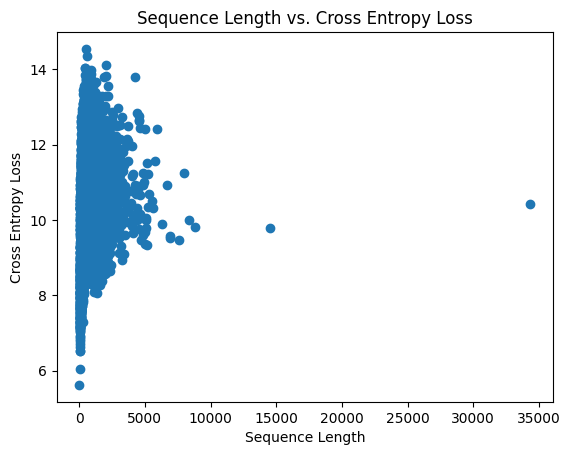

In [10]:
# Create a scatter plot
plt.scatter(sequence_length, accuracy)

# Label the axes
plt.xlabel('Sequence Length')
plt.ylabel('Cross Entropy Loss')

# Add a title
plt.title('Sequence Length vs. Cross Entropy Loss')

# Display the plot
plt.show()

To get a better visualization, limit it to sequences below 10k length

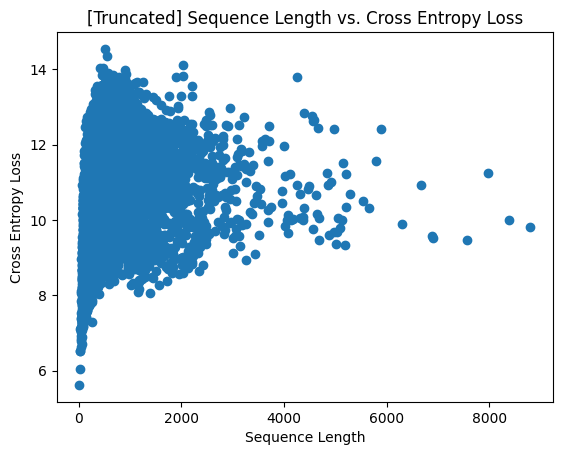

In [11]:
reduced_s_len = []
reduced_acc = []

# remove outliers
for id, s_len in enumerate(sequence_length):
    if s_len <= 10000:
        reduced_s_len.append(sequence_length[id])
        reduced_acc.append(accuracy[id])

# Create a scatter plot
plt.scatter(reduced_s_len, reduced_acc)

# Label the axes
plt.xlabel('Sequence Length')
plt.ylabel('Cross Entropy Loss')

# Add a title
plt.title('[Truncated] Sequence Length vs. Cross Entropy Loss')

# Display the plot
plt.show()

## Latency/Time Log

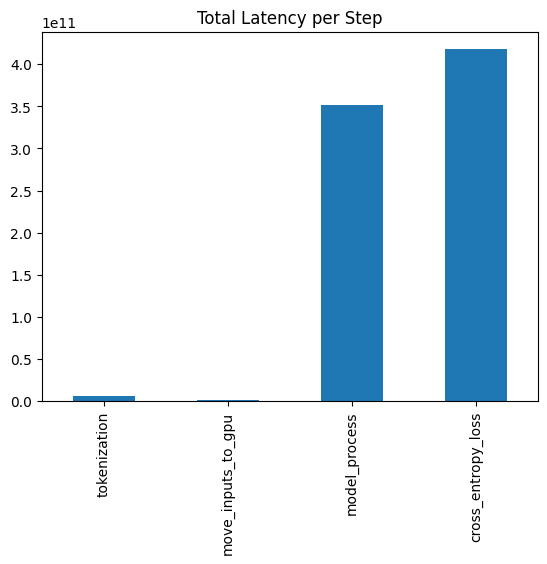

In [12]:
# latency = pd.DataFrame(columns=['start', 'tokenize', 'move_to_gpu', 'model', "end"])
# get_cel = get cross entropy loss
latency_df = pd.DataFrame(columns=['tokenization', 'move_inputs_to_gpu', 'model_process', 'cross_entropy_loss'])

latency_df["tokenization"] = latency["tokenize"] - latency["start"]
latency_df["move_inputs_to_gpu"] = latency["move_to_gpu"] - latency["tokenize"]
latency_df["model_process"] = latency["model"] - latency["move_to_gpu"]
latency_df["cross_entropy_loss"] = latency["end"] - latency["model"]

latency_sums = latency_df.sum()
# Create a bar plot
latency_sums.plot(kind='bar')

# Add title and labels
plt.title('Total Latency per Step')

# Display the plot
plt.show()

### Latency & GPU Usage vs Sequence Length

In [13]:
gpu_util_df.head()

,timestamp,tag,duration,nvidia_gpu_0
0,1.711184e+09,run,1.104349,123414
1,1.711184e+09,run,0.134293,9510
2,1.711184e+09,run,0.029499,0
3,1.711184e+09,run,0.052751,0
4,1.711184e+09,run,0.035619,0


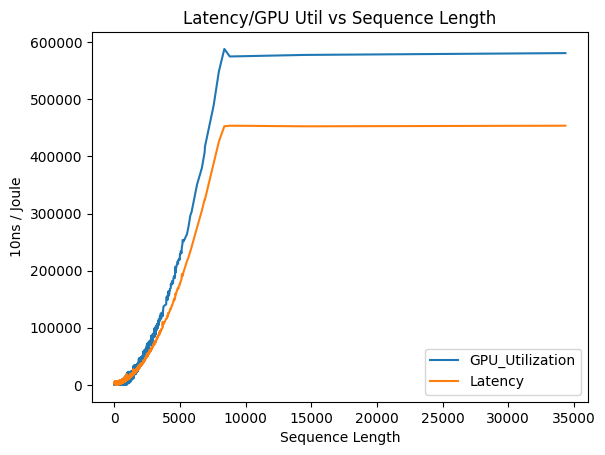

In [14]:
# Normalize Duration
duration = gpu_util_df["duration"] * 100000

lat_gpu_slen = {"Latency": duration, "GPU_Utilization": gpu_util_df["nvidia_gpu_0"], "Sequence_Length": sequence_length}
lat_gpu_slen_df = pd.DataFrame(lat_gpu_slen)
lat_gpu_slen_df = lat_gpu_slen_df.sort_values(by = 'Sequence_Length')

# Plot multiple lines
plt.plot(lat_gpu_slen_df["Sequence_Length"], lat_gpu_slen_df["GPU_Utilization"], label='GPU_Utilization')
plt.plot(lat_gpu_slen_df["Sequence_Length"], lat_gpu_slen_df["Latency"], label='Latency')

plt.xlabel('Sequence Length')
plt.ylabel('10ns / Joule')

plt.title("Latency/GPU Util vs Sequence Length")
plt.legend()

plt.show()

Remove Outliers by limiting it to 10k

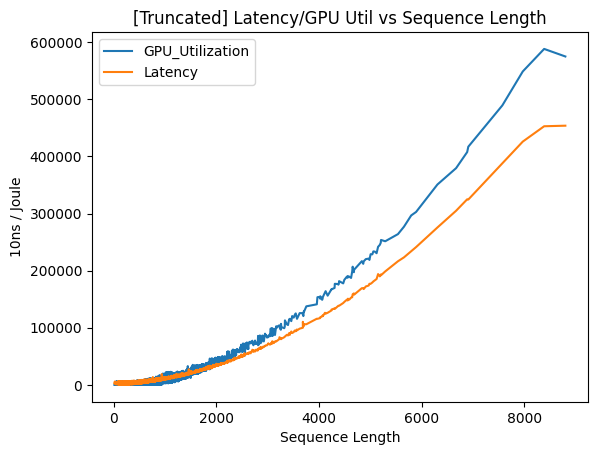

In [15]:
reduced_lat_gpu_slen_df = lat_gpu_slen_df[lat_gpu_slen_df["Sequence_Length"] <= 10000]

# Plot multiple lines
plt.plot(reduced_lat_gpu_slen_df["Sequence_Length"], reduced_lat_gpu_slen_df["GPU_Utilization"], label='GPU_Utilization')
plt.plot(reduced_lat_gpu_slen_df["Sequence_Length"], reduced_lat_gpu_slen_df["Latency"], label='Latency')

plt.xlabel('Sequence Length')
plt.ylabel('10ns / Joule')

plt.title("[Truncated] Latency/GPU Util vs Sequence Length")
plt.legend()

plt.show()